# Classically simulating circuits with OBP

In this guide, you will learn how to classically simulate `QuantumCircuit` instances to estimate expectation values entirely through the means of OBP.

Since OBP will take an observable and backpropagate it through a given circuit, the "simulation" of a circuit amounts to computing the expectation value of the target observable with respect to this circuit.
As you will see later, the `qiskit-addon-obp` package is even capable of handling simple noise models, allowing you to compute noisy expectation values, too!

## Constructing an example circuit

For the purposes of this guide, we will use the same example circuit as in the [Pauli term truncation guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html):

In [1]:
import rustworkx.generators
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import (
    PauliOrderStrategy,
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import combine_slices, slice_by_gate_types

# we generate a linear chain of 10 qubits
num_qubits = 10
linear_chain = rustworkx.generators.path_graph(num_qubits)

# we use an arbitrary XY model
hamiltonian = generate_xyz_hamiltonian(
    linear_chain,
    coupling_constants=(0.05, 0.02, 0.0),
    ext_magnetic_field=(0.02, 0.08, 0.0),
    pauli_order_strategy=PauliOrderStrategy.InteractionThenColor,
)
# we evolve for some time
circuit = generate_time_evolution_circuit(hamiltonian, synthesis=LieTrotter(reps=3), time=2.0)
# slice the circuit by gate type
slices = slice_by_gate_types(circuit)

However, the above is purely the circuit describing the time evolution under a chosen Hamiltonian.
We also need an initial state to start from, with respect to which we compute the expectation values of our observable.

Of course, we could choose the all-zero (or vacuum) state as our initial state, but to show how one would insert their own initial state, we choose a different one below.

One possibility, would be to prepend the initial state to our time-evolution circuit above: `circuit.compose(initial_state, front=True)`.
But since we have already sliced our `circuit`, it is easier to simply insert the initial state as the first slice, which we do below.

In this way, we can simply replace the first slice with another initial state, if we want to exchange that in the future, without having to recompute our slices.

In [2]:
from qiskit.circuit import QuantumCircuit

initial_state = QuantumCircuit(num_qubits)
for i in range(0, num_qubits, 2):
    initial_state.x(i)

slices.insert(0, initial_state)

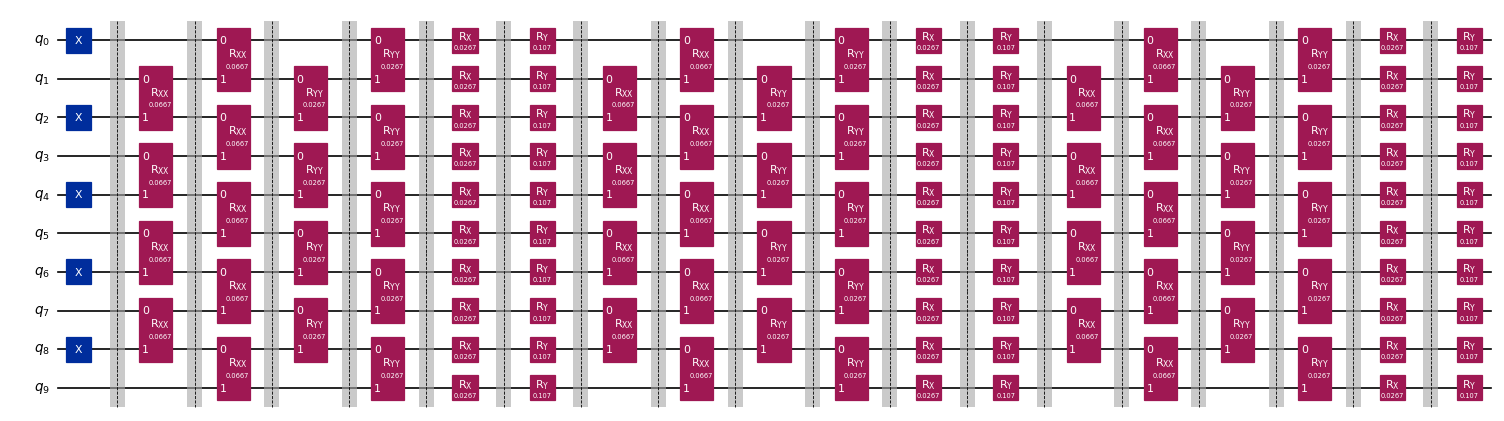

In [3]:
# for visualization purposes only, we recombine the slices with barriers between them and draw the resulting circuit
combine_slices(slices, include_barriers=True).draw("mpl", fold=50, scale=0.6)

## Simulating a noiseless expectation value

As our target observable, we choose the `ZZ` observable on the central qubits:

In [4]:
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp("IIIIZZIIII")

At this point, we are already set to classically simulate the expectation value using OBP.
To do so, we simply provide the _all_ the slices to the `backpropagate` method, like so:

In [5]:
from qiskit_addon_obp import backpropagate

vacuum_state_obs, _, metadata = backpropagate(obs, slices)

We have now backpropagated our target observable `obs` through the _entire_ circuit (**including** the `initial_state` which we placed on `slices[0]`) resulting in a new `SparsePauliOp` whose expectation value we obtain by projecting it on the _vacuum state_ (`|00...00>`).

This can be achieved in a straight forward manner by summing up the coefficients of all Pauli terms defined in the computational basis:

In [6]:
vacuum_state_obs.coeffs[~vacuum_state_obs.paulis.x.any(axis=1)].sum()

np.complex128(-0.8285688012239535+4.9487770271457865e-20j)

As a sanity check (and to prove that this works) we can compare our result against Qiskit's `Statevector`:

In [7]:
from qiskit.quantum_info import Statevector

Statevector(combine_slices(slices)).expectation_value(obs)

np.complex128(-0.8285687255430366+0j)

### Some notes on performance

The computational efficiency of the `backpropagate` call above will heavily depend on many things, including:
- the structure of the `circuit`
- the method of slicing the circuit
- the target observable
- the truncation parameters

Since the `backpropagate` method simplifies the observable after every _slice_ has been applied, the number of gates in a slice can dramatically influence the computational burden.
The most aggressive strategy in terms of operator simplification can be achieved by slicing your circuit into slices of individual gates.

Additionally, you can leverage all of the truncation mechanism built into the `backpropagate` method.
We did not do so above, effectively resulting in an exact expectation value, but you can learn how to in the [Pauli term truncation guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html).

## Simulating a noisy expectation value

The `qiskit-addon-obp` package also supports handling of noise models in the form of `PauliLindbladError`s.
This is especially useful when you have characterized the noise model of the 2-qubit layers in your circuit, for example using the [`NoiseLearner`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/noise-learner-noise-learner).

In this section, you will see how you can use the `LayerError` objects returned by the `NoiseLearner` to compute noisy expectation values using OBP.

### Obtaining a noise model

Normally, you would execute the `NoiseLearner` to obtain a noise model of your specific circuit.
To avoid complexity (and randomness) in this tutorial, we will refrain from doing so, and instead hard-code some noise model for our circuit below.

However, we make sure that the structure of our data matches that of the [`NoiseLearnerResult`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/noise-learner-result).

In its current (non-transpiled) form, our circuit contains 4 unique layers of 2-qubit gates:
- `slices[1]`: which has `Rxx` gates acting on all odd pairs of qubits
- `slices[2]`: which has `Rxx` gates acting on all even pairs of qubits
- `slices[3]`: which has `Ryy` gates acting on all odd pairs of qubits
- `slices[4]`: which has `Ryy` gates acting on all even pairs of qubits

In the cell below, we manually construct 4 `LayerError` instances for each one of these layers with some randomized error rates.

In [8]:
import numpy as np
from qiskit.quantum_info import PauliList
from qiskit_ibm_runtime.utils.noise_learner_result import LayerError, PauliLindbladError

# fmt: off
pauli_errors_even = ['IIIIIIIIIX', 'IIIIIIIIIY', 'IIIIIIIIIZ', 'IIIIIIIIXI', 'IIIIIIIIXX', 'IIIIIIIIXY', 'IIIIIIIIXZ', 'IIIIIIIIYI', 'IIIIIIIIYX', 'IIIIIIIIYY', 'IIIIIIIIYZ', 'IIIIIIIIZI', 'IIIIIIIIZX', 'IIIIIIIIZY', 'IIIIIIIIZZ', 'IIIIIIIXII', 'IIIIIIIXXI', 'IIIIIIIXYI', 'IIIIIIIXZI', 'IIIIIIIYII', 'IIIIIIIYXI', 'IIIIIIIYYI', 'IIIIIIIYZI', 'IIIIIIIZII', 'IIIIIIIZXI', 'IIIIIIIZYI', 'IIIIIIIZZI', 'IIIIIIXIII', 'IIIIIIXXII', 'IIIIIIXYII', 'IIIIIIXZII', 'IIIIIIYIII', 'IIIIIIYXII', 'IIIIIIYYII', 'IIIIIIYZII', 'IIIIIIZIII', 'IIIIIIZXII', 'IIIIIIZYII', 'IIIIIIZZII', 'IIIIIXIIII', 'IIIIIXXIII', 'IIIIIXYIII', 'IIIIIXZIII', 'IIIIIYIIII', 'IIIIIYXIII', 'IIIIIYYIII', 'IIIIIYZIII', 'IIIIIZIIII', 'IIIIIZXIII', 'IIIIIZYIII', 'IIIIIZZIII', 'IIIIXIIIII', 'IIIIXXIIII', 'IIIIXYIIII', 'IIIIXZIIII', 'IIIIYIIIII', 'IIIIYXIIII', 'IIIIYYIIII', 'IIIIYZIIII', 'IIIIZIIIII', 'IIIIZXIIII', 'IIIIZYIIII', 'IIIIZZIIII', 'IIIXIIIIII', 'IIIXXIIIII', 'IIIXYIIIII', 'IIIXZIIIII', 'IIIYIIIIII', 'IIIYXIIIII', 'IIIYYIIIII', 'IIIYZIIIII', 'IIIZIIIIII', 'IIIZXIIIII', 'IIIZYIIIII', 'IIIZZIIIII', 'IIXIIIIIII', 'IIXXIIIIII', 'IIXYIIIIII', 'IIXZIIIIII', 'IIYIIIIIII', 'IIYXIIIIII', 'IIYYIIIIII', 'IIYZIIIIII', 'IIZIIIIIII', 'IIZXIIIIII', 'IIZYIIIIII', 'IIZZIIIIII', 'IXIIIIIIII', 'IXXIIIIIII', 'IXYIIIIIII', 'IXZIIIIIII', 'IYIIIIIIII', 'IYXIIIIIII', 'IYYIIIIIII', 'IYZIIIIIII', 'IZIIIIIIII', 'IZXIIIIIII', 'IZYIIIIIII', 'IZZIIIIIII', 'XIIIIIIIII', 'XXIIIIIIII', 'XYIIIIIIII', 'XZIIIIIIII', 'YIIIIIIIII', 'YXIIIIIIII', 'YYIIIIIIII', 'YZIIIIIIII', 'ZIIIIIIIII', 'ZXIIIIIIII', 'ZYIIIIIIII', 'ZZIIIIIIII']
pauli_errors_odd = ['IIIIIIIIXI', 'IIIIIIIIYI', 'IIIIIIIIZI', 'IIIIIIIXII', 'IIIIIIIXXI', 'IIIIIIIXYI', 'IIIIIIIXZI', 'IIIIIIIYII', 'IIIIIIIYXI', 'IIIIIIIYYI', 'IIIIIIIYZI', 'IIIIIIIZII', 'IIIIIIIZXI', 'IIIIIIIZYI', 'IIIIIIIZZI', 'IIIIIIXIII', 'IIIIIIXXII', 'IIIIIIXYII', 'IIIIIIXZII', 'IIIIIIYIII', 'IIIIIIYXII', 'IIIIIIYYII', 'IIIIIIYZII', 'IIIIIIZIII', 'IIIIIIZXII', 'IIIIIIZYII', 'IIIIIIZZII', 'IIIIIXIIII', 'IIIIIXXIII', 'IIIIIXYIII', 'IIIIIXZIII', 'IIIIIYIIII', 'IIIIIYXIII', 'IIIIIYYIII', 'IIIIIYZIII', 'IIIIIZIIII', 'IIIIIZXIII', 'IIIIIZYIII', 'IIIIIZZIII', 'IIIIXIIIII', 'IIIIXXIIII', 'IIIIXYIIII', 'IIIIXZIIII', 'IIIIYIIIII', 'IIIIYXIIII', 'IIIIYYIIII', 'IIIIYZIIII', 'IIIIZIIIII', 'IIIIZXIIII', 'IIIIZYIIII', 'IIIIZZIIII', 'IIIXIIIIII', 'IIIXXIIIII', 'IIIXYIIIII', 'IIIXZIIIII', 'IIIYIIIIII', 'IIIYXIIIII', 'IIIYYIIIII', 'IIIYZIIIII', 'IIIZIIIIII', 'IIIZXIIIII', 'IIIZYIIIII', 'IIIZZIIIII', 'IIXIIIIIII', 'IIXXIIIIII', 'IIXYIIIIII', 'IIXZIIIIII', 'IIYIIIIIII', 'IIYXIIIIII', 'IIYYIIIIII', 'IIYZIIIIII', 'IIZIIIIIII', 'IIZXIIIIII', 'IIZYIIIIII', 'IIZZIIIIII', 'IXIIIIIIII', 'IXXIIIIIII', 'IXYIIIIIII', 'IXZIIIIIII', 'IYIIIIIIII', 'IYXIIIIIII', 'IYYIIIIIII', 'IYZIIIIIII', 'IZIIIIIIII', 'IZXIIIIIII', 'IZYIIIIIII', 'IZZIIIIIII']
# fmt: on

np.random.seed(42)

layer_error_odd_xx = LayerError(
    circuit=slices[1],
    qubits=list(range(num_qubits)),
    error=PauliLindbladError(
        PauliList(pauli_errors_odd),
        0.0001 + 0.0004 * np.random.rand(len(pauli_errors_odd)),
    ),
)

layer_error_even_xx = LayerError(
    circuit=slices[2],
    qubits=list(range(num_qubits)),
    error=PauliLindbladError(
        PauliList(pauli_errors_even),
        0.0001 + 0.0004 * np.random.rand(len(pauli_errors_even)),
    ),
)

layer_error_odd_yy = LayerError(
    circuit=slices[3],
    qubits=list(range(num_qubits)),
    error=PauliLindbladError(
        PauliList(pauli_errors_odd),
        0.0001 + 0.0004 * np.random.rand(len(pauli_errors_odd)),
    ),
)

layer_error_even_yy = LayerError(
    circuit=slices[4],
    qubits=list(range(num_qubits)),
    error=PauliLindbladError(
        PauliList(pauli_errors_even),
        0.0001 + 0.0004 * np.random.rand(len(pauli_errors_even)),
    ),
)

If you would have used the `NoiseLearner` to identify the unique 2-qubit gate layers of your circuit and characterize their noise, you would obtain a `NoiseLearnerResult` object.
This result would contain a list of `LayerError` objects, just like the ones we have manually constructed above.

For each unique 2-qubit layer, the `LayerError` contains:
- the `QuantumCircuit` representing that 2-qubit gate layer
- the qubit indices which this circuit is acting upon
- the `PauliLindbladError` which represents the characterized noise model of this layer

The `PauliLindbladError` will contain two objects:
- the list of Pauli errors that have been characterized
- the error rates corresponding to each one of those Pauli errors

Normally, the list of Pauli errors will be sparse. More specifically, it will contain the single-qubit Pauli errors on all qubits that have gates acting upon them as well as the two-qubit Pauli errors on all those qubits that are connected.

### Inserting the noisy layers into our circuit

In the previous section, we have specifically constructed one `LayerError` for each of our known unique 2-qubit gate layers.
This means, we know which `LayerError` matches a specific one of our slices exactly.

Normally, when using the `LayerError`, you will need to figure out what the unique 2-qubit gate layer is, and where it occurs inside of your circuit.
You will then need to adjust your `circuit` and/or `slices` to insert the `LayerError` accordingly.
How to do this in the general case, is beyond the scope of this how-to guide.
**TODO: link to external documentation, once it exists!**

Here, our life is simpler because we know which slice a `LayerError` corresponds to.
Therefore, it is now just a matter of inserting new slices to represent the noise.

Note, that we must wrap each `PauliLindbladError` from `LayerError.error` in a `PauliLindbladErrorInstruction` for it to be a valid `QuantumCircuit` instruction.

In [9]:
from qiskit_addon_obp.utils.noise import PauliLindbladErrorInstruction

noisy_slices = []
for slice_ in slices:
    if slice_ == layer_error_even_xx.circuit:
        noisy_slices.append(
            QuantumCircuit.from_instructions(
                [(PauliLindbladErrorInstruction(layer_error_even_xx.error), slice_.qubits)]
            )
        )
    elif slice_ == layer_error_odd_xx.circuit:
        noisy_slices.append(
            QuantumCircuit.from_instructions(
                [(PauliLindbladErrorInstruction(layer_error_odd_xx.error), slice_.qubits)]
            )
        )
    elif slice_ == layer_error_even_yy.circuit:
        noisy_slices.append(
            QuantumCircuit.from_instructions(
                [(PauliLindbladErrorInstruction(layer_error_even_yy.error), slice_.qubits)]
            )
        )
    elif slice_ == layer_error_odd_yy.circuit:
        noisy_slices.append(
            QuantumCircuit.from_instructions(
                [(PauliLindbladErrorInstruction(layer_error_odd_yy.error), slice_.qubits)]
            )
        )
    noisy_slices.append(slice_)

We can check our work and draw the circuit below:

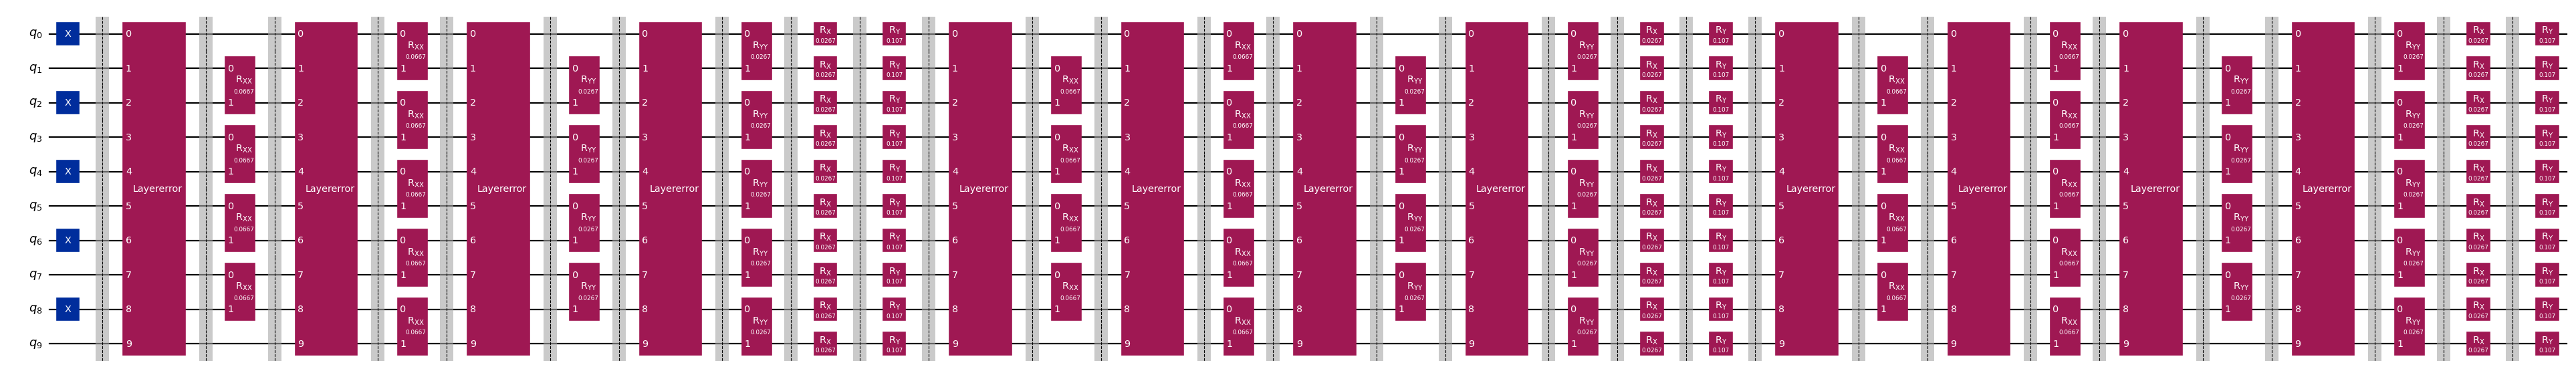

In [10]:
combine_slices(noisy_slices, include_barriers=True).draw("mpl", fold=100, scale=0.8)

### Simulating a noisy expectation value

At this point, classically simulating the expectation value works exactly the same as before, just

In [11]:
vacuum_state_noisy_obs, _, metadata = backpropagate(obs, noisy_slices)

In [12]:
vacuum_state_noisy_obs.coeffs[~vacuum_state_noisy_obs.paulis.x.any(axis=1)].sum()

np.complex128(-0.7230801696448901+7.082755280463563e-19j)

We point out again, that multiple performance concerns should be considered.
Please go back to the [corresponding section above](#some-notes-on-performance).